# A quick tutorial on using Wosis

Before we start, some known issues:

* Methods - especially plotting - switch from relying on Pandas DataFrames to Metaknowledge Collections.
This is because some things are easier to accomplish with one or the other. In the future, I hope to consolidate these to use just one, not a mishmash of both. 

* Some documentation is currently missing

Suggestions on how to improve usability is appreciated, and can be made by [submitting an issue](https://github.com/ConnectedSystems/wosis/issues) with a 'usability' tag.

The cell below shows the Python version in use for this guide. Versions equal to and above should be fine.

In [1]:
import sys
print(sys.version_info)

sys.version_info(major=3, minor=5, micro=6, releaselevel='final', serial=0)


There are two options to install Wosis for development use:

1) clone the project with `git` (the dollar sign represents the terminal prompt)

```bash
$ git clone https://github.com/ConnectedSystems/wosis.git
$ cd wosis
$ pip install git+https://github.com/ConnectedSystems/metaknowledge.git@add-collections
$ pip install git+https://github.com/titipata/wos_parser.git@master
$ pip install -e .
```

2) download, and extract, the project files from the [github repo](https://github.com/ConnectedSystems/wosis) (look for the green button on the right hand side)

```bash
$ pip install git+https://github.com/ConnectedSystems/metaknowledge.git@add-collections
$ pip install git+https://github.com/titipata/wos_parser.git@master
$ pip install -e .
```

Note the period (`.`) - yes it is important!

The first two `pip install` commands downloads and installs specific package versions that are required by Wosis.

Import packages

In [2]:
import wosis
import pandas as pd
import metaknowledge as mk
import json

Load Web of Science configuration file (this assumes the relevant file is in the same place as this notebook).

Remember not to share this file with anyone, or store it in a publicly accessible repository of any sort.

The `config.yml` file should hold your Web of Science username and password, like so:

```yaml
wos:
  user: username
  password: password
```

In [3]:
wos_config = wosis.load_config("config.yml")

Create a dictionary of search terms.

In [4]:
# dollar sign ($) is a wildcard used to match British and American spellings
# e.g. flavo$r matches both flavour and flavor
# see https://images.webofknowledge.com/images/help/WOS/hs_wildcards.html
search_terms = {
    "inclusive_kw": ("Integrated Model$ing", ),  # Keywords to include (NOTE THE TRAILING COMMA FOR SINGLE ENTRIES)
    "exclusive_kw": ("chemical", "industry", "cancer", "gene"), # Keywords to exclude
    "exclusive_jo": ('PSYCHOL*', ),  # Journals to exclude (the * tries to match anything after 'PSYCHOL')
    "subject_area": ("ENVIRONMENTAL SCIENCES", "WATER RESOURCES", "ENGINEERING ENVIRONMENTAL", "INTERDISCIPLINARY APPLICATIONS"),
}

Then build a list of queries.

The below generates a query string that we will send to Web of Science. Look at the guide here for an explanation:

http://ipscience-help.thomsonreuters.com/wosWebServicesLite/WebServiceOperationsGroup/WebServiceOperations/g2/user_query.html

In [5]:
topics = [wosis.build_query(search_terms), ]
topics

['TS=(("Integrated Model$ing") NOT ("chemical" OR "industry" OR "cancer" OR "gene")) NOT SO=("PSYCHOL*") AND WC=("ENVIRONMENTAL SCIENCES" OR "WATER RESOURCES" OR "ENGINEERING ENVIRONMENTAL" OR "INTERDISCIPLINARY APPLICATIONS")']

Now we send off the query.

Strangely, the time span of interest is not accepted as part of the WoS query, but we can specify this separately.

The `%%time` Jupyter magic command is there so we know how long this process took.

For very large amounts of records, getting the data can take a long time.

Sometimes the retrieval process fails - this could be due to high amounts of traffic to the WoS servers. Most times there's no other option other than to try again.

In [6]:
%%time
overwrite = False  # Do not overwrite previous identical search if it exists
id_to_query, query_recs = wosis.query(topics, overwrite, wos_config, time_span={'begin': '2014-01-01', 'end': '2017-12-31'})

Authenticated (SID: 6EQ8PPTiAhEAjjMEahw)


c:\userdata\takuyai\owncloud\projects\wosis\wosis\query.py:289: UserWarning: Using cached results...
  warnings.warn("Using cached results...")


Got 273 records
Wall time: 1.98 s


We can get the publication records from the query result set directly. Remember, we only sent one query so it will be the first item in the dictionary

In [7]:
RC = list(query_recs.values())[0]

print("Corpora consists of", len(RC), "Publications")

Corpora consists of 273 Publications


`id_to_query` is a dictionary that maps a result ID to the query that was sent.

In [8]:
id_to_query

{'72e7af00b238db01d2b12d9a3c6a4fb6': 'TS=(("Integrated Model$ing") NOT ("chemical" OR "industry" OR "cancer" OR "gene")) NOT SO=("PSYCHOL*") AND WC=("ENVIRONMENTAL SCIENCES" OR "WATER RESOURCES" OR "ENGINEERING ENVIRONMENTAL" OR "INTERDISCIPLINARY APPLICATIONS")'}

`query_recs` is a dictionary that maps a result ID to the matching publication set.

The `wosis.query()` function will write out the query_id information in a text file so you know which dataset is associated with which query. The default location is a directory called `tmp`. Read the documentation for the `wosis.query()` function for more information.

In this example, the unique ID for the query we just sent is `72e7af00b238db01d2b12d9a3c6a4fb6` (as you can see in the above cell).

The resulting data is cached in RIS format.

Wosis, through Metaknowledge, can read such RIS formatted data, for example exported from a reference manager such as EndNote, Mendeley, or Zotero (and others). 

In this example the dataset is cached in a `txt` file labelled with the `query_id`.

The associated dataset can then be read back in like so:

```python
RC = wosis.load_query_results('72e7af00b238db01d2b12d9a3c6a4fb6', file_loc='tmp')
```

Otherwise, we can get the publication records from the query result set directly, as we did above

```python

# Get the ID of the query result set:
query_id = list(id_to_query)[0]

print("Query ID: ", query_id, "\nQuery String:", id_to_query[query_id], "\n")

# Load it in as a metaknowledge collection
RC = mk.RecordCollection("tmp/{}.txt".format(query_id))

# If we want to constrain the time frame later, this is how we do it
# RC = RC.yearSplit(0, 2017)
```

Before we do any analysis, let's write out a representative dataset.

To use it for publication (e.g. adding it to an appendix or making it available for transparency purposes) the dataset has to be stripped of the WoS generated keywords, abstract, and some other ancillary data as these are proprietary owned by Clarivate.

At the time of writing, the usage agreement states that any dataset derived from Web of Science made publicly available has to specify that it came from Clarivate, and when the data was retrieved. This has to be included inside any file you share.

Wosis can do this for you, as shown in the cell below.

First create a `data` directory in the location indicated (`..` means "the level above the current directory" which should be where this notebook is)

Don't forget to change the retrieval date!

In [9]:
wosis.export_representative_file(RC, retrieval_date='1 December 2018', data_fn='../data/repset.csv')

Now the fun begins.

Analysis setup:

In [10]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

Basic analysis can be done with Pandas, but more complicated stuff is made simple by included Wosis helper functions

For the purposes of this tutorial, lets assume that publications without DOIs are unusable for our analysis.

The cell below will convert the records to a Pandas DataFrame, and then remove rows with blank DOIs.

In [11]:
corpora_df = wosis.rec_to_df(RC)
corpora_df, removed_pubs = wosis.constrain.remove_empty_DOIs(corpora_df)

Removing 17 records with no DOIs


We can also filter by partial match on Journal name and titles.

These methods will print out the number of articles removed for each search string.

*WARNING:* This example uses Pandas DataFrames. Future versions of Wosis will apply the changes to a Metaknowledge collection instead

In [12]:
from wosis.analysis import remove_by_journals, remove_by_title

# List of unrelated Journals - will be matched by partial string
unrelated_jo = ['PSYCHOL', 'BIOINFO']

# Think of the parameter order like "with this dataset, remove these unrelated journals"
corpora_df = remove_by_journals(corpora_df, unrelated_jo)

# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

PSYCHOL: 0
BIOINFO: 0


,AU,SO,title,year
0,"Elsawah, Sondoss|Pierce, Suzanne A.|Hamilton, ...",ENVIRONMENTAL MODELLING & SOFTWARE,An overview of the system dynamics process for...,2017
1,"Srivastava, P. K.|Singh, Raj Mohan",AGRICULTURAL WATER MANAGEMENT,GIS based integrated modelling framework for a...,2016
2,"Shrestha, Narayan Kumar|Leta, Olkeba Tolessa|D...",JOURNAL OF HYDROINFORMATICS,Modelling Escherichia coli dynamics in the riv...,2014
3,"Ala-aho, Pertti|Soulsby, Chris|Wang, Hailong|T...",JOURNAL OF HYDROLOGY,Integrated surface-subsurface model to investi...,2017
4,"Igos, Elorri|Besson, Mathilde|Gutierrez, Tomas...",WATER RESEARCH,Assessment of environmental impacts and operat...,2017


In [13]:
unrelated_TI = ['transportation networks', 'Travel Destination', 'portfolio optimization']

# Again, with this dataset remove these titles
corpora_df = remove_by_title(corpora_df, unrelated_TI)

# Hiding keywords and abstract for tutorial (WoS-owned IP)
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

transportation networks: 0
Travel Destination: 0
portfolio optimization: 0


,AU,SO,title,year
0,"Elsawah, Sondoss|Pierce, Suzanne A.|Hamilton, ...",ENVIRONMENTAL MODELLING & SOFTWARE,An overview of the system dynamics process for...,2017
1,"Srivastava, P. K.|Singh, Raj Mohan",AGRICULTURAL WATER MANAGEMENT,GIS based integrated modelling framework for a...,2016
2,"Shrestha, Narayan Kumar|Leta, Olkeba Tolessa|D...",JOURNAL OF HYDROINFORMATICS,Modelling Escherichia coli dynamics in the riv...,2014
3,"Ala-aho, Pertti|Soulsby, Chris|Wang, Hailong|T...",JOURNAL OF HYDROLOGY,Integrated surface-subsurface model to investi...,2017
4,"Igos, Elorri|Besson, Mathilde|Gutierrez, Tomas...",WATER RESEARCH,Assessment of environmental impacts and operat...,2017


We can then create a new Metaknowledge collection using the WOS ID

In [14]:
filtered_corpora = wosis.extract_recs(corpora_df.loc[:, 'id'], RC, name='Filtered Corpora')

Wosis has a number of convenient plotting functions. 

All of plotting functions 
* can save the resulting figure to a file by giving a file location to the `save_plot_fn` parameter.
  The figure will be saved in PNG format at 300dpi resolution.
* returns a matplotlib figure object so you can make further adjustments if desired

For example:

```python
wos_plot.plot_pub_trend(filtered_corpora, title='Publication Trend', save_plot_fn=r'C:\temp\my_figure.png')
```

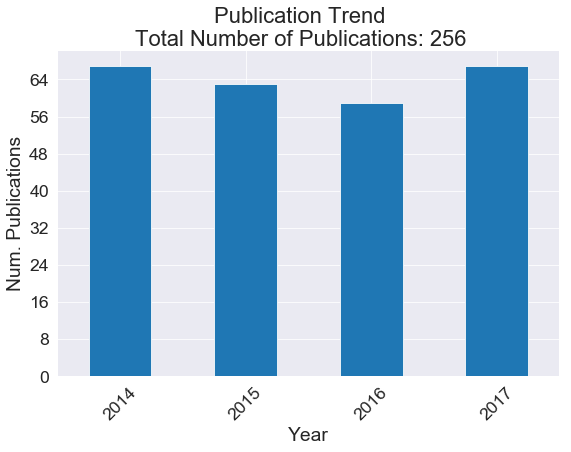

In [15]:
# Plotting out the publication trend. 
wos_plot.plot_pub_trend(filtered_corpora, title='Publication Trend', save_plot_fn=False)

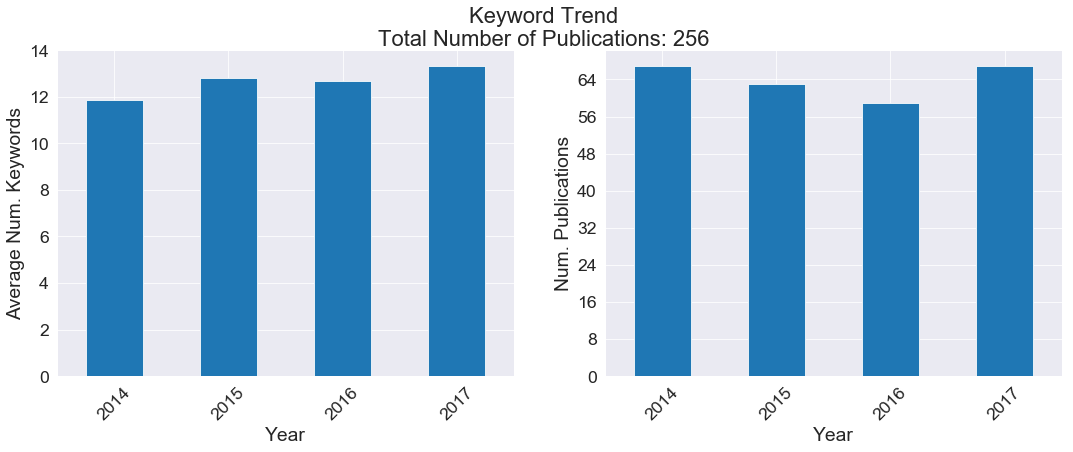

In [16]:
# Plot out the keyword trend
wos_plot.plot_kw_trend(filtered_corpora, title='Keyword Trend', save_plot_fn=False)

You can also sort the publications into specific criterias.

This matches similar words as found in the title, abstract, and keyword sections.

In [17]:
# Keyword types adapted from Zare et al. (2017)
# http://dx.doi.org/10.1016/j.jhydrol.2017.07.031

criteria = {
    'overarching': set(['uncertainty', 'adapt', 'decision support', 'management', 'gis']),
    'agri': set(['agricultur', 'farm']),
    'water': set(['hydrology', 'water', 'stream', 'aquifer']),
    'enviro': set(['environment', 'climate', 'ecology', 'ecosystem', 'biodivers']),
    'socio_economic': set(['ecosystem service', 'social', 'conflict', 'particip', 'law', 'stakehold', 'policy', 'economic'])
}

crit_matches, crit_summary = wosis.keyword_matches_by_criteria(filtered_corpora, criteria, threshold=95.0)

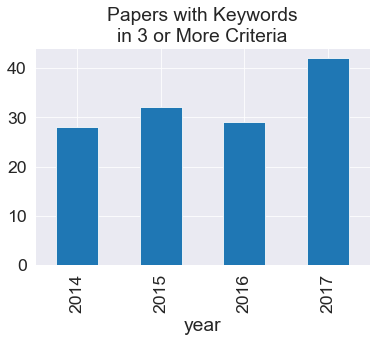

In [18]:
criteria_df = wosis.collate_keyword_criteria_matches(filtered_corpora, crit_matches)
wos_plot.plot_criteria_trend(criteria_df, threshold=3)

Remember, you can look at the documentation for anything with the question mark magic command

In [19]:
?wos_plot.plot_criteria_trend

If desired, you can search the publications for a specific keyword (or list of keywords).

Here, we look for some keywords related to the field costs - anything that is 95% similar to the given keywords is acceptable.

In [20]:
matching_records, summary = keyword_matches(filtered_corpora, ['finance', 'costs', 'capita', 'monetary'], threshold=95.0)

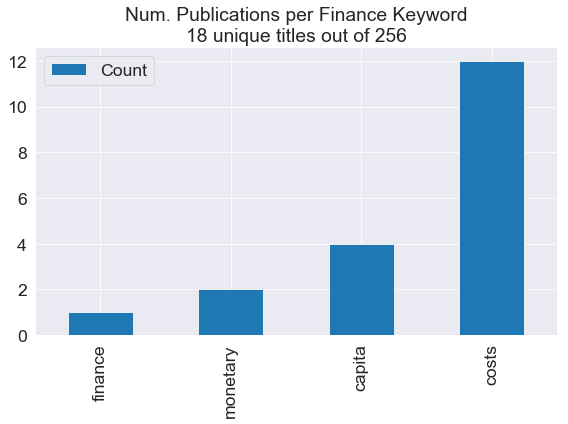

In [21]:
wos_plot.plot_pub_per_kw(matching_records, summary, filtered_corpora, kw_category='Finance')

We can then attempt to find topics of interest

*WARNING* : This is still under development and the function(s), parameter order, and return types may change

In [22]:
from wosis.analysis import find_topics, get_topic_by_id

filtered_corpora_df = pd.DataFrame(filtered_corpora.forNLP(extraColumns=["AU", "SO", "DE"]))
topic_model, trans, feature_names = find_topics(filtered_corpora_df, num_topics=10)

Topic 1: water irrigation supply demand management river resources use allocation agricultural
Topic 2: model modeling river modelling environmental management quality data models framework
Topic 3: urban modelling infrastructure water planning drainage systems stormwater tools model
Topic 4: climate change future impacts scenarios changes vulnerability population agricultural hydrological
Topic 5: flood flash rainfall hydrological catchment occurrence floods hazard temporal events
Topic 6: air traffic pollution emissions emission quality pollutants dispersion modelling stormwater
Topic 7: groundwater surface flow recharge aquifer water low model irrigation storage
Topic 8: energy transport modeling carbon electricity emissions generation nexus planning buildings
Topic 9: land use change soil erosion farm aquatic changes scenarios degradation
Topic 10: web models service component services interoperability components integration data temporal


If the identified topics are too vague or not of interest, try increasing the number of topics. Conversely, if they are too specific, try lowering the number of topics.

Say we're interested in Topic 2. The cell below shows how to get the publications for this topic.

In [23]:
id_of_interesting_topic = 2

topic_set = get_topic_by_id(topic_model, trans, id_of_interesting_topic, filtered_corpora_df)

In [24]:
print("Number of publications in topic set:", len(topic_set))

Number of publications in topic set: 125


In [25]:
# The publication set of interest!
# Hiding keywords and abstract for tutorial (WoS-owned IP)
topic_set.loc[:, ~topic_set.columns.isin(hide_columns)].head(10)  # show first 10

,AU,SO,title,year
0,"Elsawah, Sondoss|Pierce, Suzanne A.|Hamilton, ...",ENVIRONMENTAL MODELLING & SOFTWARE,An overview of the system dynamics process for...,2017
2,"Shrestha, Narayan Kumar|Leta, Olkeba Tolessa|D...",JOURNAL OF HYDROINFORMATICS,Modelling Escherichia coli dynamics in the riv...,2014
4,"Igos, Elorri|Besson, Mathilde|Gutierrez, Tomas...",WATER RESEARCH,Assessment of environmental impacts and operat...,2017
5,"Morales, Viviana M.|Mier, Jose M.|Garcia, Marc...",URBAN WATER JOURNAL,Innovative modeling framework for combined sew...,2017
7,"Sheykhi, Vahideh|Moore, Farid|Kavousi-Fard, Ab...",INTERNATIONAL JOURNAL OF RIVER BASIN MANAGEMENT,Integrated modelling with environmental parame...,2017
9,"Tian, Yong|Zheng, Yi|Zheng, Chunmiao",COMPUTERS & GEOSCIENCES,Development of a visualization tool for integr...,2016
10,"Positano, Pio|Nannucci, Marco",ACQUE SOTTERRANEE-ITALIAN JOURNAL OF GROUNDWATER,The H2020 FREEWAT participated approach for th...,2017
12,"Hughes, J. D.|Dutta, D.|Vaze, J.|Kim, S. S. H....",ENVIRONMENTAL MODELLING & SOFTWARE,An automated multi-step calibration procedure ...,2014
14,"Meng, Fanlin|Fu, Guangtao|Butler, David",WATER RESEARCH,Water quality permitting: From end-of-pipe to ...,2016
16,"Tian, Yong|Zheng, Yi|Zheng, Chunmiao|Xiao, Hon...",WATER RESOURCES RESEARCH,Exploring scale-dependent ecohydrological resp...,2015


In [26]:
topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')

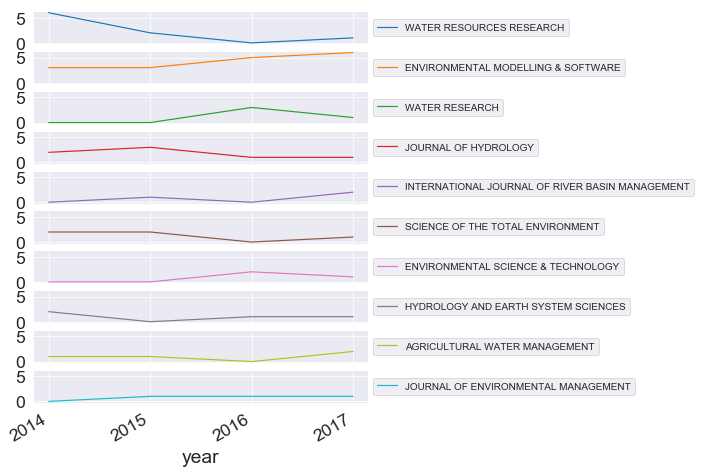

In [27]:
wos_plot.plot_journal_pub_trend(topic_recs)

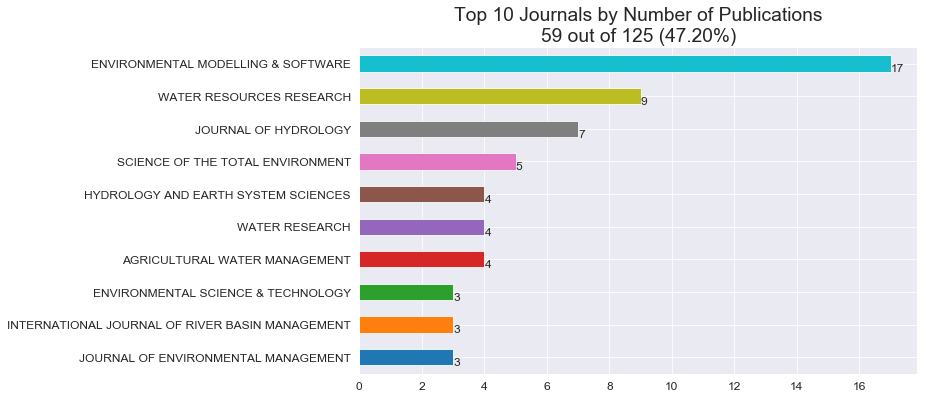

In [28]:
wos_plot.plot_pubs_per_journal(topic_recs, top_n=10, annotate=True, show_stats=True)

In [29]:
# Top 10 papers by citations
wosis.analysis.pub_citations(topic_recs)[0:10]

,Citations
Publication,
"Voinov, Alexey, 2013, 'Integronsters', integral and integrated modeling, ENVIRONMENTAL MODELLING & SOFTWARE, 39, 149, 442976565",18
"Arnold, JG, 1998, Large area hydrologic modeling and assessment - Part 1: Model development, JOURNAL OF THE AMERICAN WATER RESOURCES ASSOCIATION, 34, 73, 622773",16
"Kollet, Stefan J., 2006, Integrated surface-groundwater flow modeling: A free-surface overland flow boundary condition in a parallel groundwater flow model, ADVANCES IN WATER RESOURCES, 29, 945, 67314119",15
"Nash, J. E., 1970, River flow forecasting through conceptual models part I-A discussion of principles, J. Hydrol., 10, 282, 281488",15
"Beven, K, 2001, Equifinality, data assimilation, and uncertainty estimation in mechanistic modelling of complex environmental systems using the GLUE methodology, JOURNAL OF HYDROLOGY, 249, 11, 279450",15
"Jakeman, AJ, 2006, Ten iterative steps in development and evaluation of environmental models, ENVIRONMENTAL MODELLING & SOFTWARE, 21, 602, 66585814",15
"Moriasi, D. N., 2007, Model evaluation guidelines for systematic quantification of accuracy in watershed simulations, TRANSACTIONS OF THE ASABE, 50, 885, 77179831",12
"Kelly (Letcher), Rebecca A., 2013, Selecting among five common modelling approaches for integrated environmental assessment and management, ENVIRONMENTAL MODELLING & SOFTWARE, 47, 159, 455902900",12
"Laniak, Gerard F., 2013, Integrated environmental modeling: A vision and roadmap for the future, ENVIRONMENTAL MODELLING & SOFTWARE, 39, 3, 442976548",12


In [30]:
# # Authors with most citations (careful interpreting this - author names are grouped by surname so it is misleading)
wosis.analysis.author_citations(topic_recs)[0:10]

,Citations
Publication,
Zhang,44
Liu,40
Li,40
Wang,34
Wu,30
Chen,28
Arnold,27
Beven,24
Yang,23


Wosis can also help create links to the publications where possible

In [31]:
topic_df = wosis.link_to_pub(topic_recs)  # Creates a new column called 'DOI link'
topic_df.loc[:, ~topic_df.columns.isin(hide_columns)].head(10)

,AU,SO,title,year,DOI link
0,"Elsawah, Sondoss|Pierce, Suzanne A.|Hamilton, ...",ENVIRONMENTAL MODELLING & SOFTWARE,An overview of the system dynamics process for...,2017,https://dx.doi.org/10.1016/j.envsoft.2017.03.001
1,"Shrestha, Narayan Kumar|Leta, Olkeba Tolessa|D...",JOURNAL OF HYDROINFORMATICS,Modelling Escherichia coli dynamics in the riv...,2014,https://dx.doi.org/10.2166/hydro.2013.171
2,"Igos, Elorri|Besson, Mathilde|Gutierrez, Tomas...",WATER RESEARCH,Assessment of environmental impacts and operat...,2017,https://dx.doi.org/10.1016/j.watres.2017.09.016
3,"Morales, Viviana M.|Mier, Jose M.|Garcia, Marc...",URBAN WATER JOURNAL,Innovative modeling framework for combined sew...,2017,https://dx.doi.org/10.1080/1573062X.2015.1057183
4,"Sheykhi, Vahideh|Moore, Farid|Kavousi-Fard, Ab...",INTERNATIONAL JOURNAL OF RIVER BASIN MANAGEMENT,Integrated modelling with environmental parame...,2017,https://dx.doi.org/10.1080/15715124.2017.1300158
5,"Tian, Yong|Zheng, Yi|Zheng, Chunmiao",COMPUTERS & GEOSCIENCES,Development of a visualization tool for integr...,2016,https://dx.doi.org/10.1016/j.cageo.2015.09.019
6,"Positano, Pio|Nannucci, Marco",ACQUE SOTTERRANEE-ITALIAN JOURNAL OF GROUNDWATER,The H2020 FREEWAT participated approach for th...,2017,https://dx.doi.org/10.7343/as-2017-290
7,"Hughes, J. D.|Dutta, D.|Vaze, J.|Kim, S. S. H....",ENVIRONMENTAL MODELLING & SOFTWARE,An automated multi-step calibration procedure ...,2014,https://dx.doi.org/10.1016/j.envsoft.2013.09.024
8,"Meng, Fanlin|Fu, Guangtao|Butler, David",WATER RESEARCH,Water quality permitting: From end-of-pipe to ...,2016,https://dx.doi.org/10.1016/j.watres.2016.05.078
9,"Tian, Yong|Zheng, Yi|Zheng, Chunmiao|Xiao, Hon...",WATER RESOURCES RESEARCH,Exploring scale-dependent ecohydrological resp...,2015,https://dx.doi.org/10.1002/2015WR016881


Other analysis can easily be accomplished with Pandas